# Décembre 2023

## Combinaison des prédicteurs en utilisant le Stacking


Le stacking fait référence à une méthode pour "empiler" (mélanger) les estimateurs (modèles). Ces modèles ne sont pas forcément des modèles basiques comme dans le cas de Baggin / Boosting.     
Dans cette stratégie, on décide d'un ensemble de méthodes à appliquer aux données. Parmi ces méthodes, une sera appliquée en phase finale (produisant un **estimateur final**); les autres sont des méthodes donnant des **modèles de base**.          
Les modèles de base obtenus sont ajustés individuellement sur certaines données d'entraînement (cf. échantillonage) tandis que le résultat de l'estimateur final est obtenu à l'aide des prédictions empilées des estimateurs de base.

Dans cet exemple, on étudie le cas où différents régresseurs sont empilés ensemble et un régresseur pénalisé linéaire Ridge (pénalisé, à contraction)  est utilisé en phase finale pour établir la prédiction / modèle final.     

Notons les 3 méthodes de base : notez que deux de ces méthodes sont des méthodes **Ensembling** :    
- "Random Forest",
- "Lasso",
- "Gradient Boosting"     

Nous comparons la performance de chaque régresseur individuel (de base) avec celle de la 
stratégie  Stacking.      
Le stacking  améliore en général (ici légèrement) les performances globales.      
Voir également l'autre exemple d'emplimenet foruni.


## Téléchargement des données

 On utilise  le dataset  _`Ames Housing`_   utilisé dans le défi Kaggle.      
 C'est une BD. concernant 1 460 maisons d'habitation à Ames, Iowa, USA.     
 Chaque donnée est à l'origine décrite par 80 attributs utiliés pour prédire le prix final du logement.     
 La variable cible est le prix du logement (Sale_Price).               
 Ici,  nous n'utiliserons que les 20 attributs (variables prédictives, explicatives) les plus intéressants. Ils auront été  choisis à l'aide de la méthode GradientBoostingRegressor(), sans détailler ici comment ils ont été sélectionnées (trop long !). Notons que selon la nature des attributs (features), différentes méthodes de sélection sont possibles.
  
 L'ensemble de données sur le logement Ames est récupéré chez  _`OpenML`_.

In [39]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True, parser="pandas")
    X = df.data
    y = df.target  # Sale price

    # Les features retenus
    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X.loc[:, features]
    X, y = shuffle(X, y, random_state=0)

    # On retient une partie (600) des donénes.
    X = X.iloc[:800]
    y = y.iloc[:800]
    return X, np.log(y)


X, y = load_ames_housing()

In [40]:
X.shape

(800, 20)

In [41]:
X.head()

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
529,2007,TA,Pave,1975,GasA,NaN,816,PConc,NaN,20,Gd,Norm,2,Attchd,6,2035,1219,1Story,NaN,3
491,2006,TA,Pave,1950,GasA,None,238,CBlock,0.0,50,TA,Norm,1,Attchd,6,806,403,1.5Fin,NaN,8
459,2009,TA,Pave,1950,GasA,BrkCmn,524,CBlock,161.0,50,TA,Norm,1,Detchd,5,709,185,1.5Fin,NaN,7
279,2008,Ex,Pave,1977,GasA,BrkFace,768,CBlock,299.0,60,TA,Norm,2,Attchd,7,1160,392,2Story,NaN,3
655,2010,TA,Pave,1971,GasA,BrkFace,525,CBlock,381.0,160,TA,Norm,1,Detchd,6,525,0,2Story,NaN,3


In [42]:
y.head()

529    12.209188
491    11.798104
459    11.608236
279    12.165251
655    11.385092
Name: SalePrice, dtype: float64

In [43]:
X.columns.values # ou X.columns 

array(['YrSold', 'HeatingQC', 'Street', 'YearRemodAdd', 'Heating',
       'MasVnrType', 'BsmtUnfSF', 'Foundation', 'MasVnrArea',
       'MSSubClass', 'ExterQual', 'Condition2', 'GarageCars',
       'GarageType', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1',
       'HouseStyle', 'MiscFeature', 'MoSold'], dtype=object)

## Créer un pipeline pour prétraiter les données

 Avant de pouvoir utiliser l'ensemble de données Ames, nous devons  effectuer un prétraitement.    
 En premier lieu, nous sélectionnerons les colonnes catégorielles et numériques de l'ensemble de données pour
 construire la première étape du pipeline.


In [44]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

['HeatingQC',
 'Street',
 'Heating',
 'MasVnrType',
 'Foundation',
 'ExterQual',
 'Condition2',
 'GarageType',
 'HouseStyle',
 'MiscFeature']

Et les attributs numériques :

In [45]:
num_selector(X)

['YrSold',
 'YearRemodAdd',
 'BsmtUnfSF',
 'MasVnrArea',
 'MSSubClass',
 'GarageCars',
 'OverallQual',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'MoSold']

Ensuite, on construit des pipelines de prétraitement qui dépendent du régresseur final.      
### N.B. 
- Si le régresseur final est un modèle linéaire, il faut encoder les attributs par la convention **One-Hot**.          
- Si le régresseur final est un modèle arborescent un encodeur ordinal sera suffisant.      


**Notons** que les valeurs numériques doivent être
standardisées en entrée d'une méthode linéaire tandis que ces mêmes données numériques  peuvent être directement utilisées en l'état par une méthode  arborescent.      


Dans les 2 cas, on a besoin de traiter  les valeurs manquantes.

Nous allons d’abord concevoir le pipeline requis pour les modèles arborescents.

In [46]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

# Ordinal pour les catégoriels avec traitement des valeurs manquantes
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
# Traitement des valeurs manquantes (on prend le "mean") pour les numériques
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeefe21280>)])


Ensuite, on définit un pre-processeur si le régresseur final est une méthode linéaire.



In [47]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeefe21280>)])


## Pile de prédicteurs sur un seul ensemble de données

 Il est parfois fastidieux de trouver le modèle qui sera le plus performant sur une base de données. 
 Le Stacking offre une alternative en combinant les sorties de plusieurs modèles, sans avoir besoin de choisir un modèle spécifique. 
 La performance du Stacking  est généralement proche du meilleur modèle et peut parfois (souvent) surperformer
 les performances de prédiction de chaque modèle individuel.

 Ici, nous combinons 3 méthodes (linéaires et non linéaires) et utilisons un Régresseur Ridge final  pour combiner l'ensemble.

**N.B.** :     
Nous aurons besoin  des pipelines (voir ci-dessus) pour les 3 méthodes de base,  mais l'estimateur final
(`~sklearn.linear_model.RidgeCV()`) n'a pas besoin de prétraitement des données sachant qu'il prendra en entrée les sortie des 3 modèles de base.


In [48]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeefe21280>)])),
                ('lassocv', LassoCV())])

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeefe21280>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [50]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeefe21280>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [51]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeeffaa580>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fdeefe21280>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())



## Evaluation et plot des résultats

 Nous pouvons maintenant utiliser l’ensemble de données Ames Housing pour faire des prédictions. Nous vérifions le
 performances de chaque prédicteur individuel ainsi que celle de niotre "Stack" : celle de la pile de
 régresseurs.

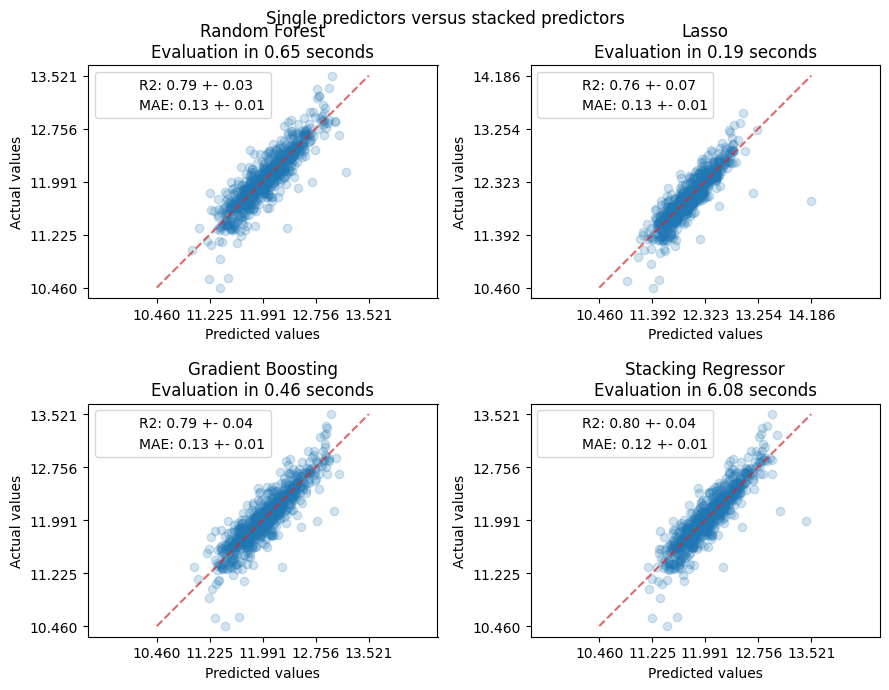

In [52]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Le régresseur final  a combiné les atouts des différents régresseurs de base.      
Cependant,  la construction de l'architecture Stacking ainsi que le temps d'exécution de la méthode finale est plus coûteux en calcul.      
PArfois, on constate (dans certains essais) que le regresseur finala une  performance inférieure aux modèles individuels.     Ici, il se comporte légèrement mieux que les modèles de base.